# Autoencoder Using ANN.

We're using an artificial neural network in the encoder and decoder architectures.

## Encoder
The encoder has 1 input layer and 1 hidden layer having 256 nodes with ReLU as activation.

## Latent Space Representation
The latent space representation or code has 7 hidden nodes. So, we're compressing the 28*28 image into a 1D vector of size 7.

## Decoder
The decoder has 1 hidden layer having 256 nodes followed by ReLU activation. The output layer has 28*28 nodes followed by Sigmoid as activation.

In [1]:
import os
import torch
import numpy as np
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms import v2 as transforms
from tqdm.auto import tqdm

device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

# convert data to torch.FloatTensor
transform = transforms.Compose([
    transforms.PILToTensor(),
    transforms.ToDtype(torch.float32, scale=True),
])

# load the training and test datasets
train_data = datasets.MNIST(root='./data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False,
                                  download=True, transform=transform)

num_workers = os.cpu_count()
batch_size = 32

train_loader = DataLoader(train_data, batch_size, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(test_data, batch_size, shuffle=False, num_workers=num_workers)

/Users/suryanshsinha/Desktop/cDCGAN/.cDCGAN/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(32, 1, 28, 28)


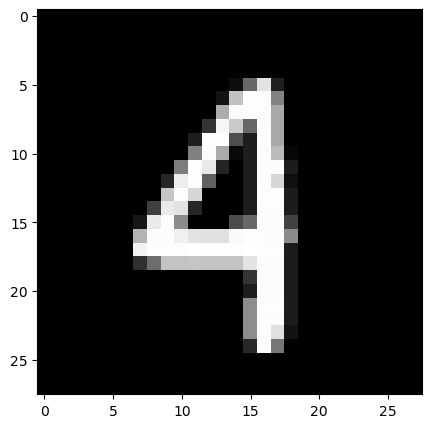

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

# obtain one batch of training images
images, labels = next(iter(train_loader))
images = images.numpy()
print(images.shape)

# get one image from the batch
img = np.squeeze(images[0])
fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

In [3]:
import torch.nn as nn

class Autoencoder(nn.Module):
  def __init__(self, encoding_dim):
    super().__init__()

    self.encoder = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28*28, 256),
        nn.ReLU(),
        nn.Linear(256, encoding_dim),
        nn.ReLU()
    )

    self.decoder = nn.Sequential(
        nn.Linear(encoding_dim, 256),
        nn.ReLU(),
        nn.Linear(256, 28*28),
        nn.Sigmoid()
    )

  def forward(self, x):
    return self.decoder(self.encoder(x))

encoding_dim = 64
model = Autoencoder(encoding_dim).to(device)
print(model)

Autoencoder(
  (encoder): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=256, bias=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=784, bias=True)
    (3): Sigmoid()
  )
)


In [4]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [5]:
n_epochs = 10
for epoch in range(1, n_epochs+1):
  train_loss = 0

  model.train()
  for images, _ in tqdm(train_loader):
    images = images.to(device)
    current_batch_size = images.size(0)
    outputs = model(images).view(current_batch_size, 1, 28, 28)
    loss = loss_fn(outputs, images)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_loss += loss.item()*current_batch_size

  train_loss = train_loss / len(train_loader)
  print('Epoch: {} | Training Loss: {:.4f}'.format(epoch, train_loss))

100%|██████████| 1875/1875 [00:12<00:00, 146.77it/s]


Epoch: 1 | Training Loss: 0.7615


100%|██████████| 1875/1875 [00:12<00:00, 154.59it/s]


Epoch: 2 | Training Loss: 0.3097


100%|██████████| 1875/1875 [00:11<00:00, 156.57it/s]


Epoch: 3 | Training Loss: 0.2419


100%|██████████| 1875/1875 [00:12<00:00, 154.17it/s]


Epoch: 4 | Training Loss: 0.2061


100%|██████████| 1875/1875 [00:12<00:00, 154.08it/s]


Epoch: 5 | Training Loss: 0.1856


100%|██████████| 1875/1875 [00:12<00:00, 152.67it/s]


Epoch: 6 | Training Loss: 0.1713


100%|██████████| 1875/1875 [00:12<00:00, 151.74it/s]


Epoch: 7 | Training Loss: 0.1620


100%|██████████| 1875/1875 [00:12<00:00, 151.98it/s]


Epoch: 8 | Training Loss: 0.1554


100%|██████████| 1875/1875 [00:12<00:00, 150.52it/s]


Epoch: 9 | Training Loss: 0.1504


100%|██████████| 1875/1875 [00:12<00:00, 152.26it/s]


Epoch: 10 | Training Loss: 0.1461


In [6]:
def show_result(dataloader):
  img, _ = next(iter(dataloader))

  # Moving images to target device
  img = img.to(device)
  
  # Plot original images
  plt.figure(figsize=(9, 3))
  for i in range(0, 9):
    plt.subplot(2, 9, i+1)
    image = img[i].cpu().permute(1, 2, 0)
    plt.imshow(image, cmap='gray')
    plt.axis(False)
  plt.suptitle(f"Original Images", fontsize=20)

  # Get the output from model and plot reconstructed images
  model.eval()
  with torch.inference_mode():
    plt.figure(figsize=(9, 3))
    output = model(img).view(img.size(0), 1, 28, 28)
    for i in range(0, 9):
      plt.subplot(2, 9, i+1)
      image = output[i].cpu().permute(1, 2, 0)
      plt.imshow(image, cmap='gray')
      plt.axis(False)
    plt.suptitle("Reconstructed Images", fontsize=20)

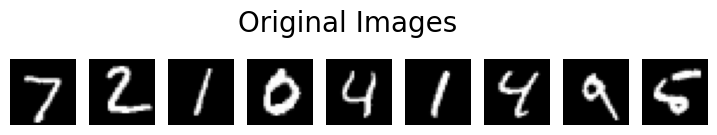

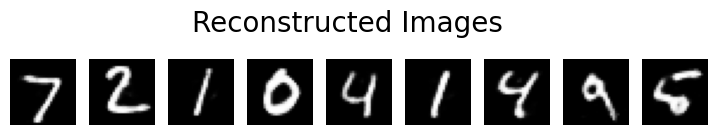

In [7]:
show_result(test_loader)